In this notebook, we aim to perform **classification** on images from the **CIFAR10** dataset using CNN networks. First, we load the dataset and apply the necessary transformations for normalization and augmentation. After that, we visualize some samples. Once we familiarize ourselves with the dataset, we proceed to design the desired convolutional network, which is explained in the relevant section. After designing the model, we move on to training and evaluating it. At the end of the first section, we analyze the feature space from different perspectives. First, using the KNN method, we examine the closest samples to each other in the feature space. Then, we cluster the data and finally visualize the outputs of the intermediate layers of the model.

In the second part of the notebook, we perform a simple transfer learning task on the trained model from the first section but using a new dataset, **CIFAR100**. To do this, we modify the final layer of the network and retrain it. Further details are provided in the relevant section. Finally, we evaluate the model’s accuracy on the new task and analyze the extracted features and how well the model generalizes. After designing and training the model, we will further analyze the extracted feature space. Finally, we will evaluate the generalization ability of the model and its extracted features on a new dataset,

# CIFAR10 Classification

## Import Libraries

Import needed libraries

In [2]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from time import time
import random
from sklearn.manifold import TSNE
import numpy as np
from random import sample
import math
import torch.optim as optim
import seaborn as sns

## Device

Set device to work with (GPU or CPU)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
from torch.utils.data import random_split, DataLoader

data_transforms = {
  'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
  ]),
  'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
  ]),
}

full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=data_transforms['train']
)

train_size = int(len(full_train_dataset) * 0.8)
valid_size = len(full_train_dataset) - train_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, valid_size])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    download=True,
    transform=data_transforms['test']
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=64, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

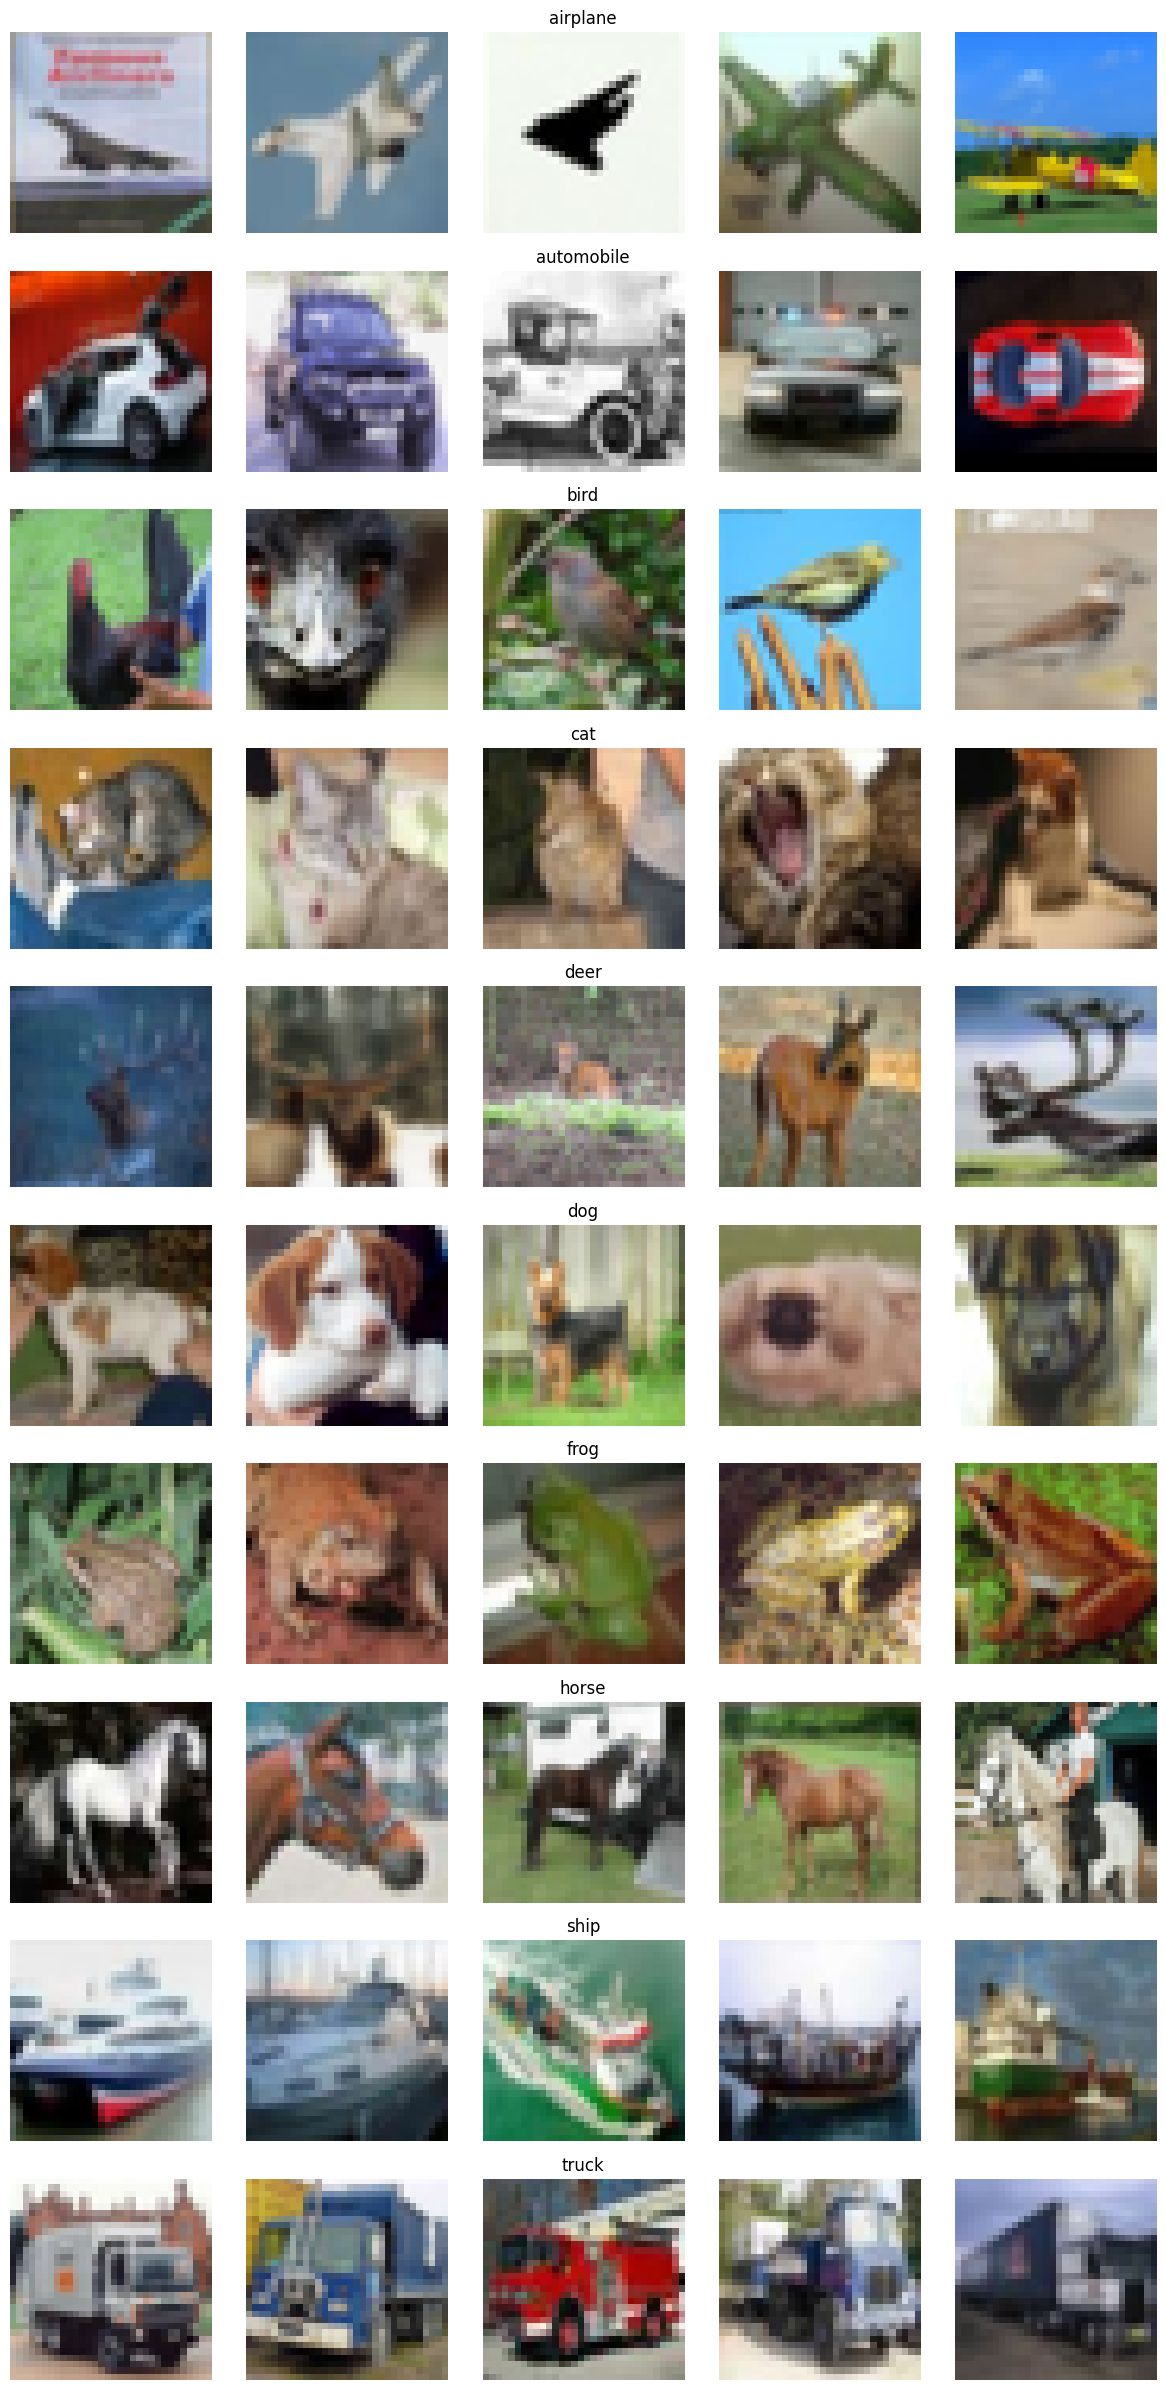

In [6]:
show_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())

class_names = show_dataset.classes

images_per_class = {class_name: [] for class_name in class_names}

for img, label in show_dataset:
    class_name = class_names[label]
    if len(images_per_class[class_name]) < 5:
        images_per_class[class_name].append(img)
    if all(len(imgs) == 5 for imgs in images_per_class.values()):
        break

fig, axes = plt.subplots(10, 5, figsize=(12, 24))

for i, class_name in enumerate(class_names):
    for j in range(5):
        axes[i, j].imshow(np.transpose(images_per_class[class_name][j], (1, 2, 0)))
        axes[i, j].axis('off')
        if j == 2:
            axes[i, j].set_title(class_name, fontsize=12)

plt.tight_layout()
plt.show()

## Model

Define your model here from scratch

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [11]:
model = ResNet(BasicBlock, [2, 5, 3, 2], num_classes=10).to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [13]:
def train_stage(model, loader, criterion, optimizer):
  model.train()
  total_loss, correct = 0, 0

  for inputs, targets in (pbar := tqdm(loader)):
    inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()

    optimizer.step()
    total_loss += loss.item()
    _, predicted = outputs.max(1)
    correct += predicted.eq(targets).sum().item()

  return total_loss / len(loader), 100. * correct / len(loader.dataset)


In [14]:
def validate_stage(model, loader, criterion):
  model.eval()
  total_loss = 0
  correct = 0
  with torch.no_grad():
      for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

  return total_loss / len(loader), 100. * correct / len(loader.dataset)

In [15]:
from torchsummary import summary

def train(model, epochs, train_loader, validation_loader, criterion, optimizer):
  train_losses, train_accs = [], []
  valid_losses, valid_accs = [], []

  for epoch in range(1, epochs):
    train_loss, train_acc = train_stage(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = validate_stage(model, validation_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

    if valid_acc >= 90:
      break

  return train_losses, train_accs, valid_losses, valid_accs

train_losses, train_accs, valid_losses, valid_accs = train(model, 50, train_loader, validation_loader, criterion, optimizer)

100%|██████████| 625/625 [00:30<00:00, 20.19it/s]


Epoch 1: Train Loss: 1.5791, Train Acc: 41.43% | Valid Loss: 1.3941, Valid Acc: 48.81%


100%|██████████| 625/625 [00:30<00:00, 20.81it/s]


Epoch 2: Train Loss: 1.1161, Train Acc: 60.17% | Valid Loss: 0.9866, Valid Acc: 64.92%


100%|██████████| 625/625 [00:29<00:00, 20.94it/s]


Epoch 3: Train Loss: 0.8998, Train Acc: 68.17% | Valid Loss: 0.9030, Valid Acc: 68.47%


100%|██████████| 625/625 [00:29<00:00, 20.85it/s]


Epoch 4: Train Loss: 0.7416, Train Acc: 73.70% | Valid Loss: 0.8469, Valid Acc: 71.95%


100%|██████████| 625/625 [00:29<00:00, 21.09it/s]


Epoch 5: Train Loss: 0.6273, Train Acc: 78.02% | Valid Loss: 0.7063, Valid Acc: 75.89%


100%|██████████| 625/625 [00:29<00:00, 21.04it/s]


Epoch 6: Train Loss: 0.5541, Train Acc: 80.40% | Valid Loss: 0.6123, Valid Acc: 78.41%


100%|██████████| 625/625 [00:29<00:00, 20.91it/s]


Epoch 7: Train Loss: 0.4973, Train Acc: 82.75% | Valid Loss: 0.5376, Valid Acc: 81.39%


100%|██████████| 625/625 [00:29<00:00, 21.12it/s]


Epoch 8: Train Loss: 0.4506, Train Acc: 84.45% | Valid Loss: 0.5065, Valid Acc: 82.89%


100%|██████████| 625/625 [00:29<00:00, 20.93it/s]


Epoch 9: Train Loss: 0.4069, Train Acc: 85.95% | Valid Loss: 0.4601, Valid Acc: 84.06%


100%|██████████| 625/625 [00:29<00:00, 21.07it/s]


Epoch 10: Train Loss: 0.3722, Train Acc: 87.19% | Valid Loss: 0.4489, Valid Acc: 84.53%


100%|██████████| 625/625 [00:29<00:00, 21.11it/s]


Epoch 11: Train Loss: 0.3406, Train Acc: 88.15% | Valid Loss: 0.4220, Valid Acc: 86.04%


100%|██████████| 625/625 [00:29<00:00, 21.14it/s]


Epoch 12: Train Loss: 0.3114, Train Acc: 89.16% | Valid Loss: 0.4159, Valid Acc: 86.20%


100%|██████████| 625/625 [00:29<00:00, 21.06it/s]


Epoch 13: Train Loss: 0.2892, Train Acc: 90.04% | Valid Loss: 0.3931, Valid Acc: 87.05%


100%|██████████| 625/625 [00:29<00:00, 20.92it/s]


Epoch 14: Train Loss: 0.2694, Train Acc: 90.65% | Valid Loss: 0.3877, Valid Acc: 86.99%


100%|██████████| 625/625 [00:29<00:00, 21.14it/s]


Epoch 15: Train Loss: 0.2447, Train Acc: 91.36% | Valid Loss: 0.3822, Valid Acc: 87.65%


100%|██████████| 625/625 [00:29<00:00, 21.12it/s]


Epoch 16: Train Loss: 0.2304, Train Acc: 91.93% | Valid Loss: 0.3936, Valid Acc: 87.16%


100%|██████████| 625/625 [00:29<00:00, 21.13it/s]


Epoch 17: Train Loss: 0.2145, Train Acc: 92.54% | Valid Loss: 0.3410, Valid Acc: 88.79%


100%|██████████| 625/625 [00:29<00:00, 21.15it/s]


Epoch 18: Train Loss: 0.1976, Train Acc: 93.17% | Valid Loss: 0.3459, Valid Acc: 88.93%


100%|██████████| 625/625 [00:29<00:00, 21.15it/s]


Epoch 19: Train Loss: 0.1788, Train Acc: 93.78% | Valid Loss: 0.3339, Valid Acc: 89.13%


100%|██████████| 625/625 [00:29<00:00, 21.13it/s]


Epoch 20: Train Loss: 0.1687, Train Acc: 94.09% | Valid Loss: 0.3648, Valid Acc: 87.99%


100%|██████████| 625/625 [00:29<00:00, 21.17it/s]


Epoch 21: Train Loss: 0.1614, Train Acc: 94.28% | Valid Loss: 0.3507, Valid Acc: 89.33%


100%|██████████| 625/625 [00:29<00:00, 21.16it/s]


Epoch 22: Train Loss: 0.1448, Train Acc: 94.88% | Valid Loss: 0.3456, Valid Acc: 89.35%


100%|██████████| 625/625 [00:29<00:00, 21.15it/s]


Epoch 23: Train Loss: 0.1376, Train Acc: 95.11% | Valid Loss: 0.3358, Valid Acc: 89.40%


100%|██████████| 625/625 [00:29<00:00, 21.14it/s]


Epoch 24: Train Loss: 0.1313, Train Acc: 95.34% | Valid Loss: 0.3649, Valid Acc: 89.33%


100%|██████████| 625/625 [00:29<00:00, 21.17it/s]


Epoch 25: Train Loss: 0.1162, Train Acc: 96.05% | Valid Loss: 0.3567, Valid Acc: 89.22%


100%|██████████| 625/625 [00:29<00:00, 21.16it/s]


Epoch 26: Train Loss: 0.1148, Train Acc: 95.95% | Valid Loss: 0.3822, Valid Acc: 89.31%


100%|██████████| 625/625 [00:29<00:00, 21.02it/s]


Epoch 27: Train Loss: 0.1069, Train Acc: 96.26% | Valid Loss: 0.3465, Valid Acc: 89.92%


100%|██████████| 625/625 [00:29<00:00, 20.95it/s]


Epoch 28: Train Loss: 0.0990, Train Acc: 96.47% | Valid Loss: 0.3795, Valid Acc: 89.69%


100%|██████████| 625/625 [00:29<00:00, 21.14it/s]


Epoch 29: Train Loss: 0.0995, Train Acc: 96.50% | Valid Loss: 0.3729, Valid Acc: 89.40%


100%|██████████| 625/625 [00:29<00:00, 21.17it/s]


Epoch 30: Train Loss: 0.0838, Train Acc: 97.05% | Valid Loss: 0.3646, Valid Acc: 89.94%


100%|██████████| 625/625 [00:29<00:00, 21.15it/s]


Epoch 31: Train Loss: 0.0836, Train Acc: 96.99% | Valid Loss: 0.3621, Valid Acc: 90.24%


### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [17]:
torch.save(model.state_dict(), './model_statedict.pt')

# model = ResNetCIFAR10(BasicBlock, [2, 5, 3, 2], num_classes=10).to(device)
# model.load_state_dict(torch.load('./model_statedict.pt'))
# model.eval()

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

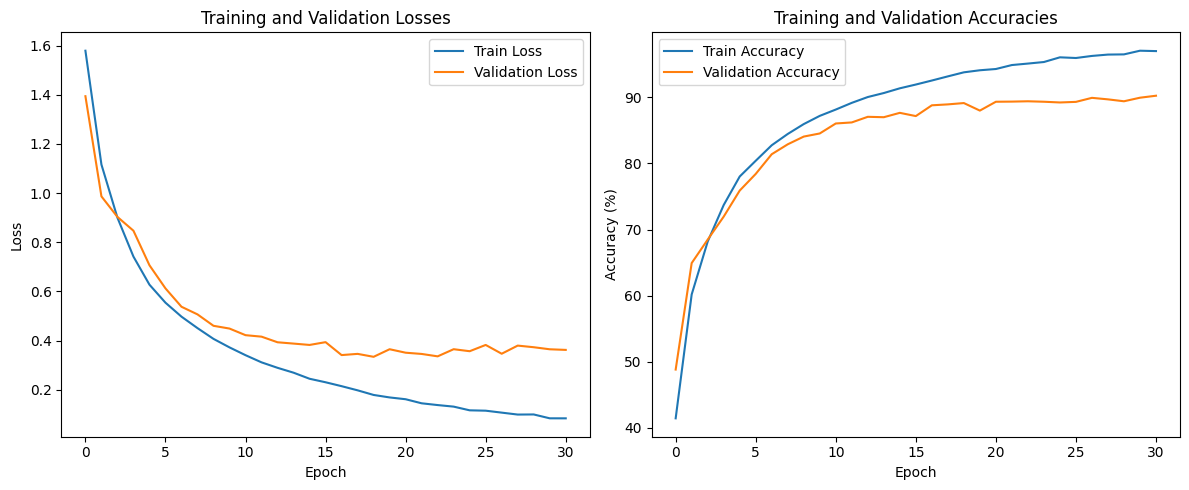

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [19]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    incorrect_examples = []

    with torch.no_grad():
      for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

        incorrect_idx = (predicted != targets)
        incorrect_inputs = inputs[incorrect_idx]
        incorrect_targets = targets[incorrect_idx]
        incorrect_preds = predicted[incorrect_idx]

        for inp, trgt, pred in zip(incorrect_inputs, incorrect_targets, incorrect_preds):
          incorrect_examples.append((inp, trgt.item(), pred.item()))

    return total_loss / len(loader), 100. * correct / len(loader.dataset), incorrect_examples

test_loss, test_acc, incorrect_examples = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.1133, Test Accuracy: 96.74%


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

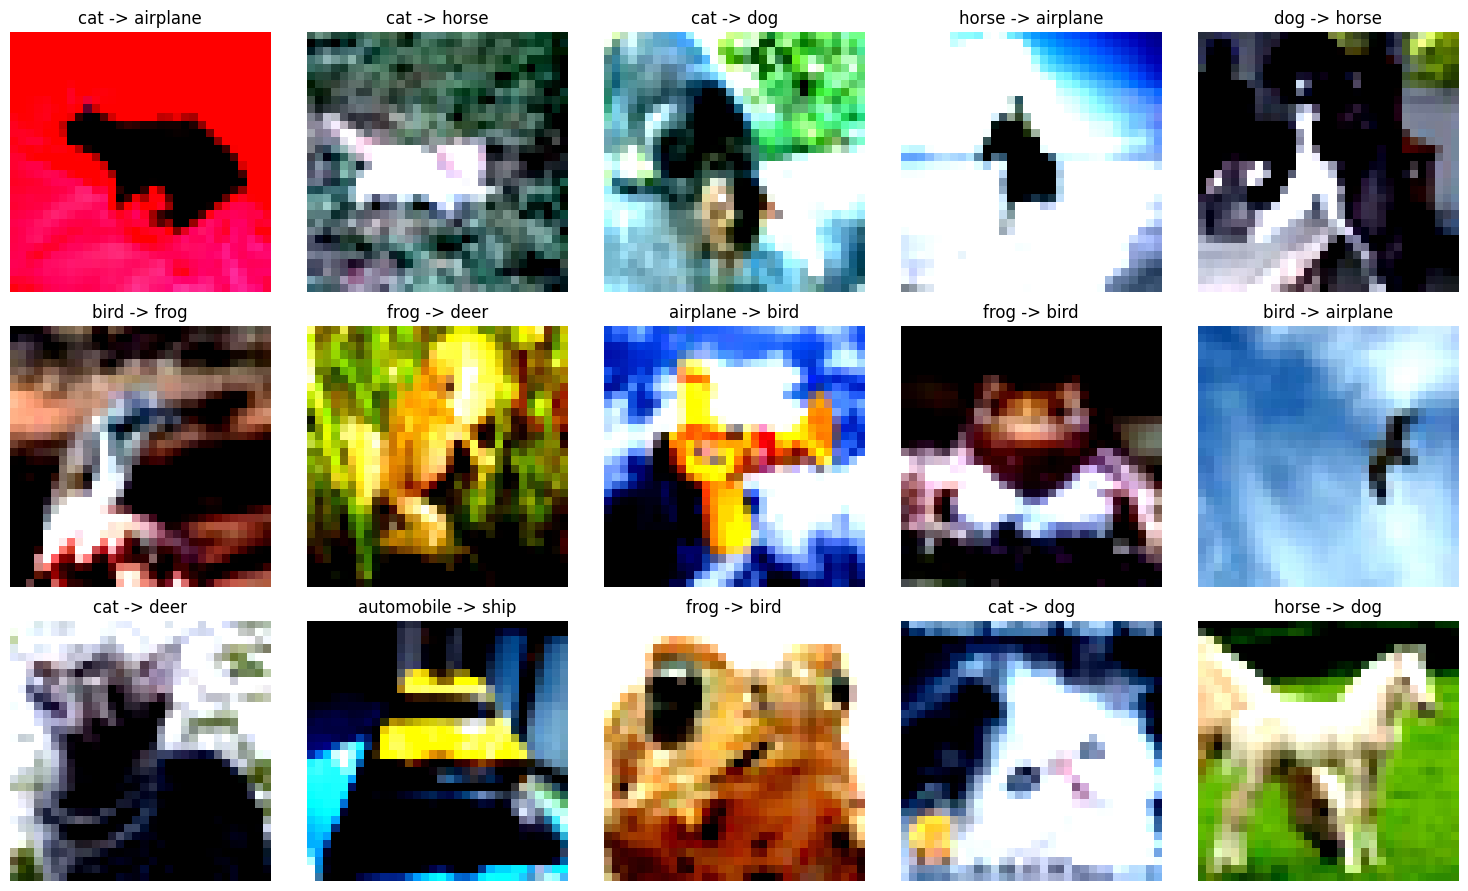

In [24]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for idx, (inp, correct, incorrect) in enumerate(incorrect_examples[:15]):
    ax = axes[idx // 5, idx % 5]
    inp = inp / 2 + 0.5
    npimg = inp.cpu().numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)).astype(np.float64))
    ax.set_title(f'{class_names[correct]} -> {class_names[incorrect]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [47]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = torch.nn.Sequential(*list(model.children())[:-1]) # for test

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

feature_extractor = FeatureExtractor(model)
feature_extractor.eval()

train_features = []
train_images = []
train_labels = []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        features = feature_extractor(images)
        train_features.append(features.cpu().numpy())
        train_images.extend(images.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_features = np.concatenate(train_features, axis=0)
train_images = np.stack(train_images)
train_labels = np.array(train_labels)

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** To find the nearest neighbors in the feature space, you can use any library of your choice.

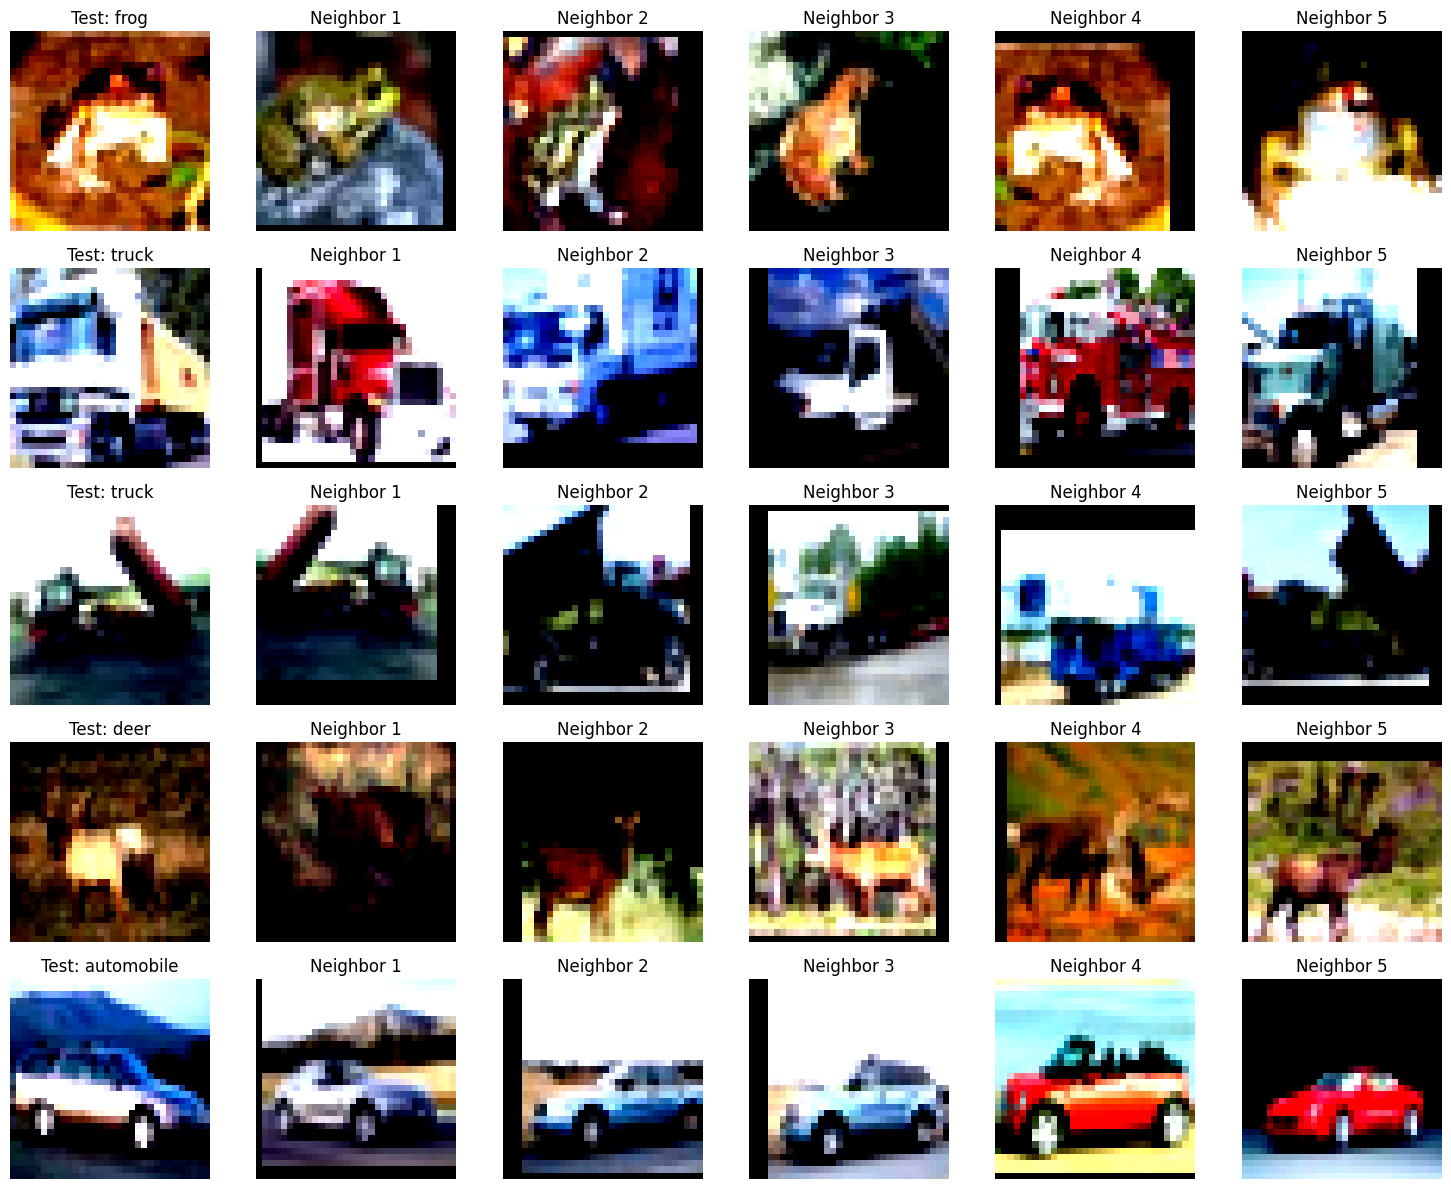

In [48]:
correct_samples = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, preds = outputs.max(1)
        correct_mask = preds == labels

        for img, label, pred, is_correct in zip(images, labels, preds, correct_mask):
            if is_correct:
                correct_samples.append((img.cpu(), label.item()))
            if len(correct_samples) >= 5:
                break
        if len(correct_samples) >= 5:
            break

fig, axes = plt.subplots(5, 6, figsize=(15, 12))

for i, (img, label) in enumerate(correct_samples):
    img_batch = img.unsqueeze(0).cuda()
    with torch.no_grad():
        feature = feature_extractor(img_batch).cpu().numpy()

    similarities = cosine_similarity(feature, train_features)[0]
    nearest_indices = similarities.argsort()[-5:][::-1]

    axes[i, 0].imshow(np.transpose((img.numpy() * 0.5 + 0.5), (1, 2, 0)))
    axes[i, 0].set_title(f"Test: {class_names[label]}")
    axes[i, 0].axis('off')

    for j, idx in enumerate(nearest_indices):
        neighbor_img = train_images[idx]
        axes[i, j+1].imshow(np.transpose((neighbor_img * 0.5 + 0.5), (1, 2, 0)))
        axes[i, j+1].set_title(f"Neighbor {j+1}")
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [49]:
M = 2000
indices = np.random.choice(train_features.shape[0], size=M, replace=False)
sampled_features = train_features[indices]
sampled_labels = train_labels[indices]

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(sampled_features)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

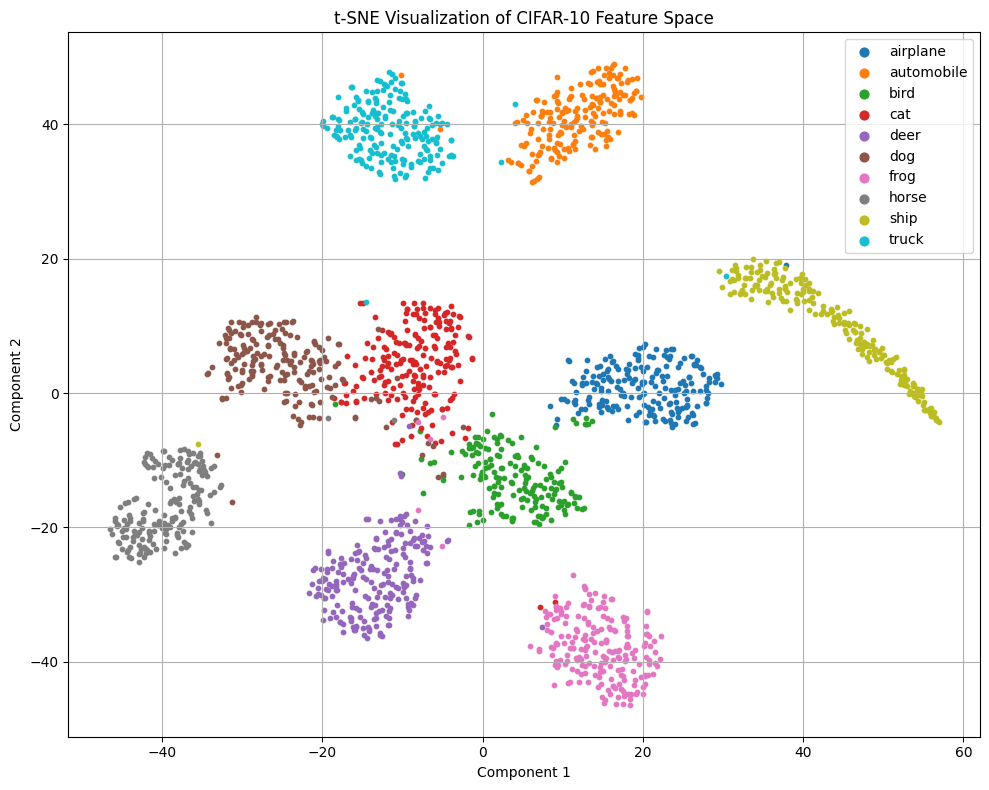

In [50]:
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    idx = sampled_labels == i
    plt.scatter(tsne_features[idx, 0], tsne_features[idx, 1], label=class_names[i], s=10)

plt.legend(markerscale=2)
plt.title("t-SNE Visualization of CIFAR-10 Feature Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

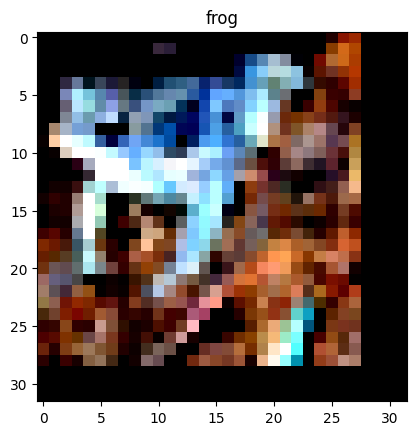

In [63]:
# already shuffled
sample_img, sample_label = next(iter(train_loader))
sample_img = sample_img[0].unsqueeze(0)
sample_label = classes[sample_label[0].item()]

plt.imshow(np.transpose(intended_image, (1, 2, 0)))
plt.title(classes[intended_label.item()])
plt.show()

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



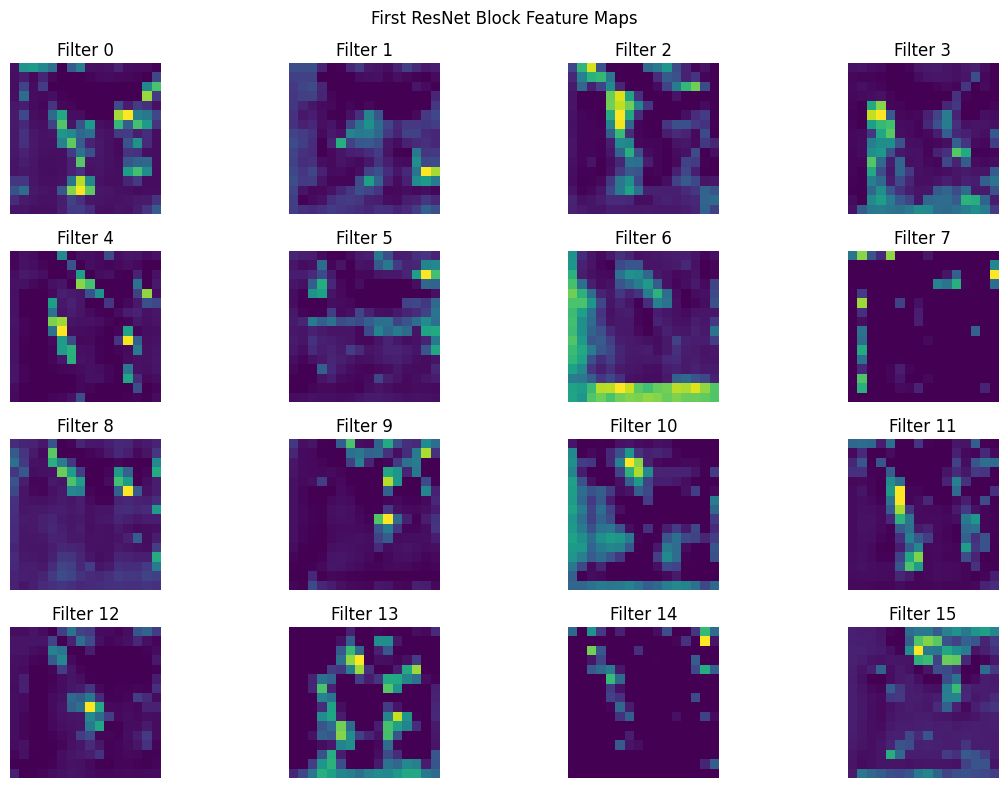

In [66]:
clipped_model = torch.nn.Sequential(
    *list(model.children())[:5]  # after the layers of conv1, bn1, relu, layer1
)

with torch.no_grad():
    feature_maps = clipped_model(sample_img.cuda()).squeeze(0).cpu()

plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(feature_maps[i])
    plt.title(f'Filter {i}')
    plt.axis('off')
plt.suptitle("First ResNet Block Feature Maps")
plt.tight_layout()
plt.show()


## CIFAR100

In this section, we aim to test the trained model on a different dataset. For this purpose, we will use the CIFAR100 dataset, which is similar to CIFAR10 but has different types and numbers of classes. In order for the model to perform well on the new dataset, we need to modify the last layer of the model. As you know from the previous section, the last layer of the model is a linear layer that maps the features to the number of classes. In this section, due to the increase in the number of classes, we plan to modify this layer and train the new linear layer with the new dataset. Note that all other layers and weights of the model will remain fixed and unchanged; only the last layer will be retrained.

### Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms.

In [67]:
data_transforms = {
  'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
  ]),
  'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
  ]),
}

full_train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=data_transforms['train']
)

train_size = int(len(full_train_dataset) * 0.8)
valid_size = len(full_train_dataset) - train_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, valid_size])

test_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    download=True,
    transform=data_transforms['test']
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=64, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2)


100%|██████████| 169M/169M [00:03<00:00, 48.9MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [68]:
classes = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee",
    "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee",
    "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster",
    "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse",
    "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum",
    "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train",
    "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]
print(len(classes))

100


### Visualization

Visualize 1 random images from each class.

- **Hint**:  You can use `plt.subplots` for visualization

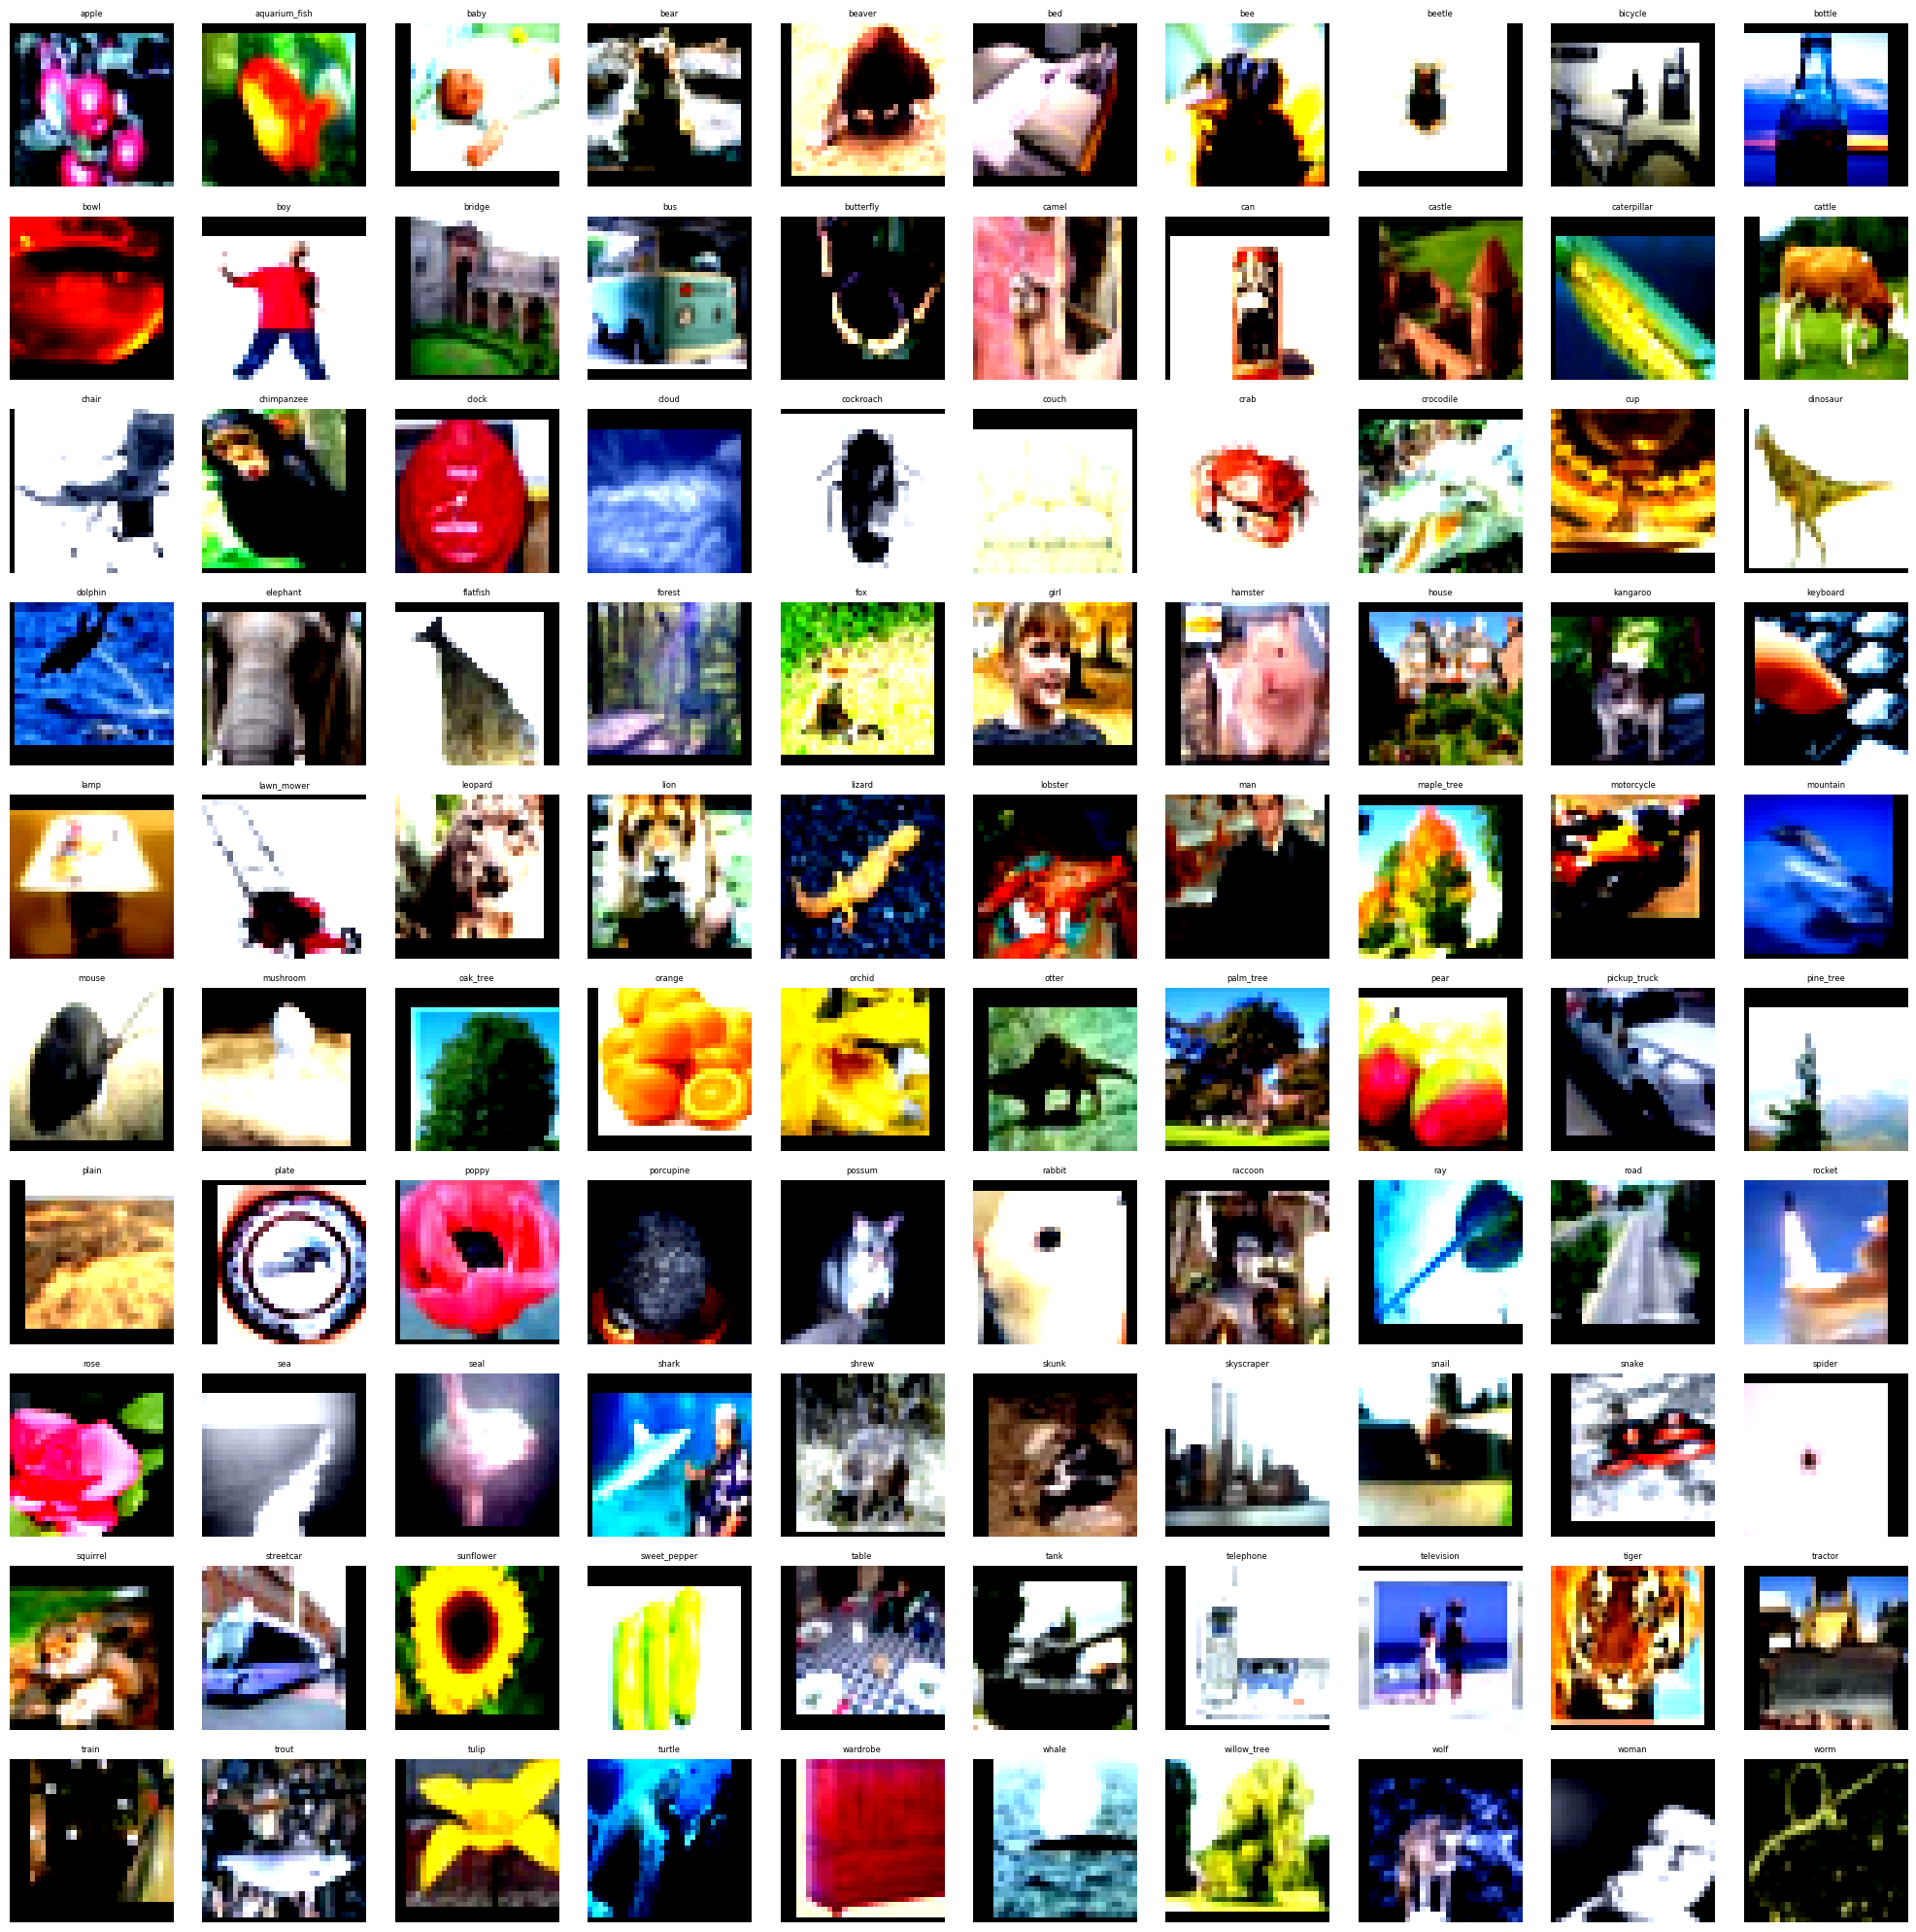

In [69]:
found_classes = set()
class_examples = dict()

with torch.no_grad():
    for images, labels in train_loader:
        for img, label in zip(images, labels):
            if label.item() not in found_classes:
                class_examples[label.item()] = img
                found_classes.add(label.item())
            if len(found_classes) == 100:
                break
        if len(found_classes) == 100:
            break

plt.figure(figsize=(20, 20))
for idx, (label, img) in enumerate(sorted(class_examples.items())):
    plt.subplot(10, 10, idx + 1)
    img = img.numpy() * 0.5 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f"{classes[label]}", fontsize=6)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Modify Model

Change the final linear layer of the model according to the new number of classes And freeze all other layers.
- Do not forgot to move model to `device`

In [ ]:
class ResNetCIFAR100(torch.nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = torch.nn.Sequential(*list(model.children())[:-1]) # all layers except the last
        self.fc = nn.Linear(512, 100)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [79]:
model = ResNet(BasicBlock, [2, 5, 3, 2], num_classes=100).to(device)
checkpoint = torch.load("./model_statedict.pt")
if 'fc.weight' in checkpoint:
    del checkpoint['fc.weight']
    del checkpoint['fc.bias']
model.load_state_dict(checkpoint, strict=False)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


<ipython-input-79-7ff69af977d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./model_statedict.pt")


### Train

Train the Model (Only Last Layer)

In [80]:
train_losses, train_accs, valid_losses, valid_accs = train(model, 50, train_loader, validation_loader, criterion, optimizer)

100%|██████████| 625/625 [00:11<00:00, 52.10it/s]


Epoch 1: Train Loss: 3.3845, Train Acc: 19.49% | Valid Loss: 3.0231, Valid Acc: 25.67%


100%|██████████| 625/625 [00:12<00:00, 51.42it/s]


Epoch 2: Train Loss: 2.9161, Train Acc: 27.92% | Valid Loss: 2.8414, Valid Acc: 28.91%


100%|██████████| 625/625 [00:12<00:00, 51.79it/s]


Epoch 3: Train Loss: 2.7785, Train Acc: 30.22% | Valid Loss: 2.7412, Valid Acc: 31.07%


100%|██████████| 625/625 [00:12<00:00, 51.46it/s]


Epoch 4: Train Loss: 2.6903, Train Acc: 31.74% | Valid Loss: 2.6943, Valid Acc: 32.11%


100%|██████████| 625/625 [00:12<00:00, 51.86it/s]


Epoch 5: Train Loss: 2.6229, Train Acc: 33.48% | Valid Loss: 2.6298, Valid Acc: 33.94%


100%|██████████| 625/625 [00:11<00:00, 52.53it/s]


Epoch 6: Train Loss: 2.5717, Train Acc: 34.48% | Valid Loss: 2.6177, Valid Acc: 33.46%


100%|██████████| 625/625 [00:11<00:00, 53.11it/s]


Epoch 7: Train Loss: 2.5349, Train Acc: 35.30% | Valid Loss: 2.5609, Valid Acc: 35.07%


100%|██████████| 625/625 [00:11<00:00, 52.94it/s]


Epoch 8: Train Loss: 2.5002, Train Acc: 36.13% | Valid Loss: 2.5315, Valid Acc: 35.56%


100%|██████████| 625/625 [00:11<00:00, 53.33it/s]


Epoch 9: Train Loss: 2.4765, Train Acc: 36.69% | Valid Loss: 2.5141, Valid Acc: 36.18%


100%|██████████| 625/625 [00:11<00:00, 53.23it/s]


Epoch 10: Train Loss: 2.4457, Train Acc: 37.16% | Valid Loss: 2.4888, Valid Acc: 36.61%


100%|██████████| 625/625 [00:11<00:00, 52.32it/s]


Epoch 11: Train Loss: 2.4202, Train Acc: 37.85% | Valid Loss: 2.4894, Valid Acc: 36.65%


100%|██████████| 625/625 [00:11<00:00, 53.42it/s]


Epoch 12: Train Loss: 2.4055, Train Acc: 38.05% | Valid Loss: 2.4525, Valid Acc: 37.76%


100%|██████████| 625/625 [00:11<00:00, 53.25it/s]


Epoch 13: Train Loss: 2.3808, Train Acc: 38.66% | Valid Loss: 2.4580, Valid Acc: 37.10%


100%|██████████| 625/625 [00:11<00:00, 53.34it/s]


Epoch 14: Train Loss: 2.3718, Train Acc: 38.70% | Valid Loss: 2.4390, Valid Acc: 37.83%


100%|██████████| 625/625 [00:11<00:00, 52.48it/s]


Epoch 15: Train Loss: 2.3554, Train Acc: 39.26% | Valid Loss: 2.4052, Valid Acc: 38.04%


100%|██████████| 625/625 [00:11<00:00, 52.26it/s]


Epoch 16: Train Loss: 2.3343, Train Acc: 39.71% | Valid Loss: 2.4103, Valid Acc: 38.31%


100%|██████████| 625/625 [00:11<00:00, 52.58it/s]


Epoch 17: Train Loss: 2.3257, Train Acc: 40.01% | Valid Loss: 2.4135, Valid Acc: 37.72%


100%|██████████| 625/625 [00:11<00:00, 52.31it/s]


Epoch 18: Train Loss: 2.3079, Train Acc: 40.31% | Valid Loss: 2.4018, Valid Acc: 38.09%


100%|██████████| 625/625 [00:11<00:00, 53.00it/s]


Epoch 19: Train Loss: 2.2977, Train Acc: 40.26% | Valid Loss: 2.3869, Valid Acc: 38.86%


100%|██████████| 625/625 [00:11<00:00, 53.31it/s]


Epoch 20: Train Loss: 2.2880, Train Acc: 40.69% | Valid Loss: 2.4131, Valid Acc: 38.24%


100%|██████████| 625/625 [00:11<00:00, 52.99it/s]


Epoch 21: Train Loss: 2.2759, Train Acc: 40.82% | Valid Loss: 2.3635, Valid Acc: 39.48%


100%|██████████| 625/625 [00:11<00:00, 53.19it/s]


Epoch 22: Train Loss: 2.2642, Train Acc: 40.79% | Valid Loss: 2.3807, Valid Acc: 39.13%


100%|██████████| 625/625 [00:11<00:00, 52.79it/s]


Epoch 23: Train Loss: 2.2589, Train Acc: 41.30% | Valid Loss: 2.3604, Valid Acc: 38.71%


100%|██████████| 625/625 [00:11<00:00, 52.82it/s]


Epoch 24: Train Loss: 2.2435, Train Acc: 41.49% | Valid Loss: 2.3399, Valid Acc: 39.63%


100%|██████████| 625/625 [00:11<00:00, 52.33it/s]


Epoch 25: Train Loss: 2.2456, Train Acc: 41.50% | Valid Loss: 2.3457, Valid Acc: 39.80%


100%|██████████| 625/625 [00:11<00:00, 53.08it/s]


Epoch 26: Train Loss: 2.2315, Train Acc: 41.78% | Valid Loss: 2.3335, Valid Acc: 39.93%


100%|██████████| 625/625 [00:11<00:00, 53.26it/s]


Epoch 27: Train Loss: 2.2264, Train Acc: 41.90% | Valid Loss: 2.3532, Valid Acc: 39.65%


100%|██████████| 625/625 [00:11<00:00, 52.66it/s]


Epoch 28: Train Loss: 2.2150, Train Acc: 42.06% | Valid Loss: 2.3410, Valid Acc: 39.49%


100%|██████████| 625/625 [00:12<00:00, 52.03it/s]


Epoch 29: Train Loss: 2.2020, Train Acc: 42.36% | Valid Loss: 2.3195, Valid Acc: 40.30%


100%|██████████| 625/625 [00:12<00:00, 51.91it/s]


Epoch 30: Train Loss: 2.2073, Train Acc: 42.09% | Valid Loss: 2.3152, Valid Acc: 40.48%


100%|██████████| 625/625 [00:11<00:00, 53.08it/s]


Epoch 31: Train Loss: 2.2002, Train Acc: 42.49% | Valid Loss: 2.3137, Valid Acc: 40.44%


100%|██████████| 625/625 [00:11<00:00, 52.60it/s]


Epoch 32: Train Loss: 2.1917, Train Acc: 42.43% | Valid Loss: 2.3266, Valid Acc: 39.93%


100%|██████████| 625/625 [00:11<00:00, 53.03it/s]


Epoch 33: Train Loss: 2.1875, Train Acc: 42.82% | Valid Loss: 2.3143, Valid Acc: 40.53%


100%|██████████| 625/625 [00:11<00:00, 53.48it/s]


Epoch 34: Train Loss: 2.1820, Train Acc: 42.62% | Valid Loss: 2.3015, Valid Acc: 40.68%


100%|██████████| 625/625 [00:11<00:00, 53.32it/s]


Epoch 35: Train Loss: 2.1776, Train Acc: 42.66% | Valid Loss: 2.3067, Valid Acc: 40.53%


100%|██████████| 625/625 [00:11<00:00, 52.19it/s]


Epoch 36: Train Loss: 2.1669, Train Acc: 43.20% | Valid Loss: 2.2897, Valid Acc: 40.53%


100%|██████████| 625/625 [00:12<00:00, 50.29it/s]


Epoch 37: Train Loss: 2.1666, Train Acc: 42.98% | Valid Loss: 2.2993, Valid Acc: 40.62%


100%|██████████| 625/625 [00:11<00:00, 52.57it/s]


Epoch 38: Train Loss: 2.1600, Train Acc: 43.23% | Valid Loss: 2.2885, Valid Acc: 40.76%


100%|██████████| 625/625 [00:12<00:00, 48.53it/s]


Epoch 39: Train Loss: 2.1494, Train Acc: 43.49% | Valid Loss: 2.3169, Valid Acc: 40.15%


100%|██████████| 625/625 [00:12<00:00, 49.60it/s]


Epoch 40: Train Loss: 2.1449, Train Acc: 43.78% | Valid Loss: 2.3062, Valid Acc: 40.65%


100%|██████████| 625/625 [00:12<00:00, 50.30it/s]


Epoch 41: Train Loss: 2.1459, Train Acc: 43.32% | Valid Loss: 2.2897, Valid Acc: 41.00%


100%|██████████| 625/625 [00:12<00:00, 50.07it/s]


Epoch 42: Train Loss: 2.1395, Train Acc: 43.63% | Valid Loss: 2.2793, Valid Acc: 40.72%


100%|██████████| 625/625 [00:13<00:00, 45.86it/s]


Epoch 43: Train Loss: 2.1420, Train Acc: 43.75% | Valid Loss: 2.2722, Valid Acc: 41.62%


100%|██████████| 625/625 [00:13<00:00, 45.48it/s]


Epoch 44: Train Loss: 2.1364, Train Acc: 43.70% | Valid Loss: 2.2780, Valid Acc: 40.76%


100%|██████████| 625/625 [00:13<00:00, 44.79it/s]


Epoch 45: Train Loss: 2.1287, Train Acc: 43.98% | Valid Loss: 2.2562, Valid Acc: 41.03%


100%|██████████| 625/625 [00:13<00:00, 46.98it/s]


Epoch 46: Train Loss: 2.1266, Train Acc: 43.77% | Valid Loss: 2.2515, Valid Acc: 41.86%


100%|██████████| 625/625 [00:13<00:00, 46.08it/s]


Epoch 47: Train Loss: 2.1169, Train Acc: 44.25% | Valid Loss: 2.2799, Valid Acc: 41.08%


100%|██████████| 625/625 [00:14<00:00, 43.34it/s]


Epoch 48: Train Loss: 2.1150, Train Acc: 44.16% | Valid Loss: 2.2715, Valid Acc: 40.65%


100%|██████████| 625/625 [00:14<00:00, 43.16it/s]


Epoch 49: Train Loss: 2.1081, Train Acc: 44.37% | Valid Loss: 2.2836, Valid Acc: 40.94%


### Test

Evaluate the Model on CIFAR-100 Test Set. 40% accuracy is sufficient.


In [81]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    incorrect_examples = []

    with torch.no_grad():
      for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

        incorrect_idx = (predicted != targets)
        incorrect_inputs = inputs[incorrect_idx]
        incorrect_targets = targets[incorrect_idx]
        incorrect_preds = predicted[incorrect_idx]

        for inp, trgt, pred in zip(incorrect_inputs, incorrect_targets, incorrect_preds):
          incorrect_examples.append((inp, trgt.item(), pred.item()))

    return total_loss / len(loader), 100. * correct / len(loader.dataset), incorrect_examples

test_loss, test_acc, incorrect_examples = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 2.0619, Test Accuracy: 45.62%


### Question
You might think that 40% accuracy is quite low. However, first of all, consider that the classification is done over 100 classes. The accuracy of a random model in this case is 1%. Also, we only changed one linear layer of the model, and the rest of the weights remained unchanged. What do you think is the reason the model can achieve a reasonably good generalization ability on a completely new dataset with just the change of one linear layer at the end?

Answer: Model learned the general features at previous learning process, now it only generalized it's previous knowledge on the new datasets and lables.

### Visualize incorrectly predicted samples from testset

Visualize *10* random images from testset that are incorrectly predicted by the model

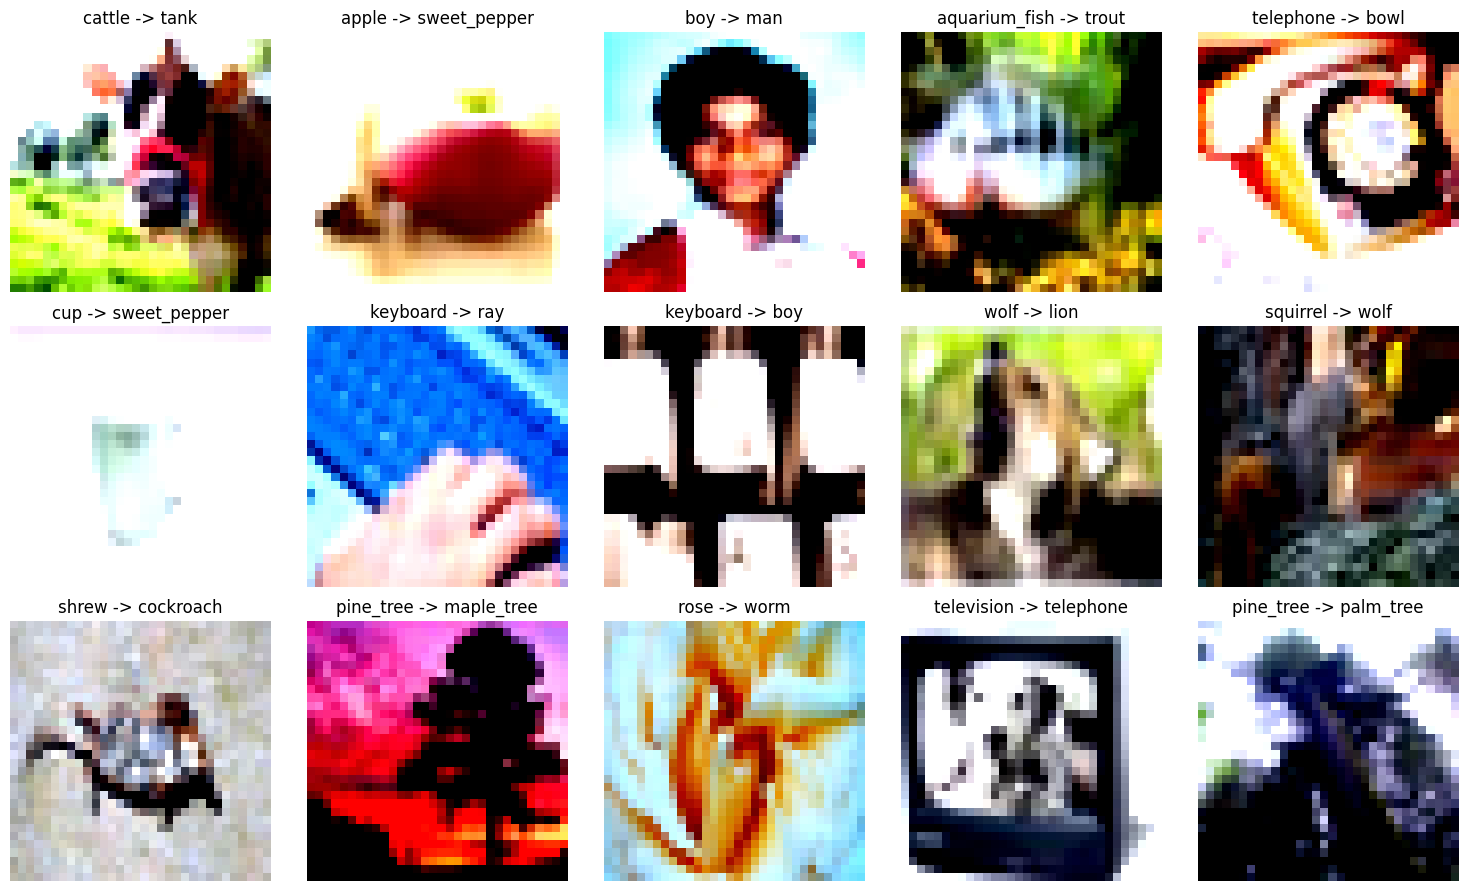

In [83]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for idx, (inp, correct, incorrect) in enumerate(incorrect_examples[:15]):
    ax = axes[idx // 5, idx % 5]
    inp = inp / 2 + 0.5
    npimg = inp.cpu().numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)).astype(np.float64))
    ax.set_title(f'{classes[correct]} -> {classes[incorrect]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Plot accuracy for each class

Plot accuracy of model on testset for each class.

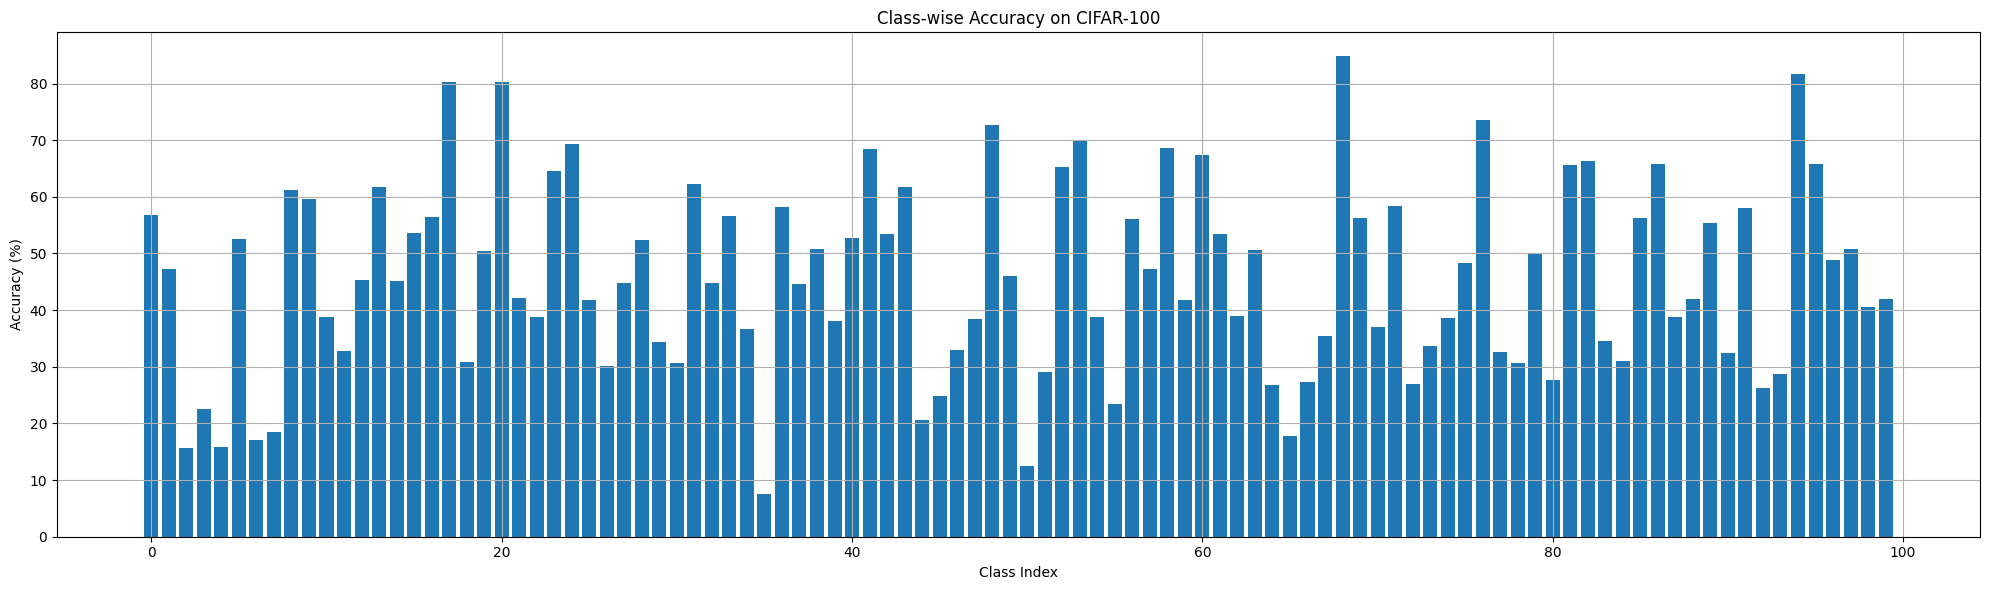

In [86]:
from collections import defaultdict

correct = defaultdict(int)
total = defaultdict(int)
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, preds = outputs.max(1)
        for label, pred in zip(labels, preds):
            total[label.item()] += 1
            if label == pred:
                correct[label.item()] += 1

accuracies = [100 * correct[i] / total[i] if total[i] > 0 else 0 for i in range(100)]

plt.figure(figsize=(20, 6))
plt.bar(range(100), accuracies)
plt.xlabel('Class Index')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy on CIFAR-100')
plt.grid(True)
plt.tight_layout()
plt.show()


### The classes with the best and worst accuracy

Based on the results from the previous section, obtain the 5 classes with the best accuracy and the 5 classes with the worst accuracy on the testset, and display one sample from each of them.

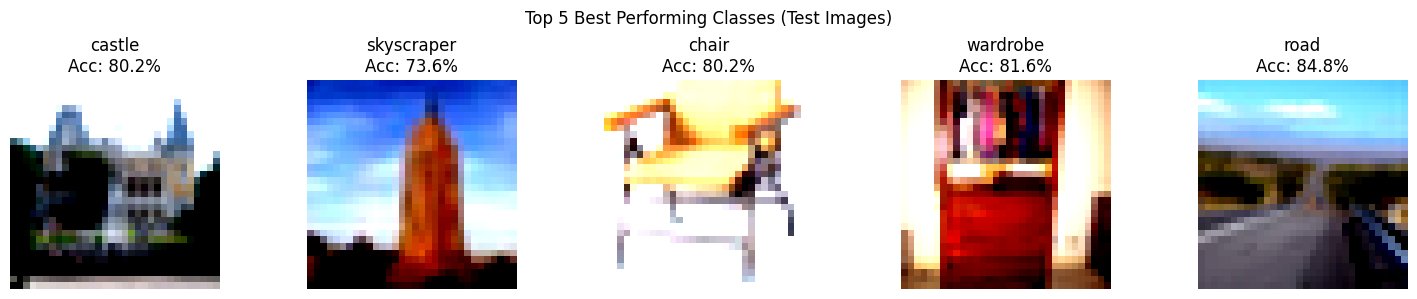

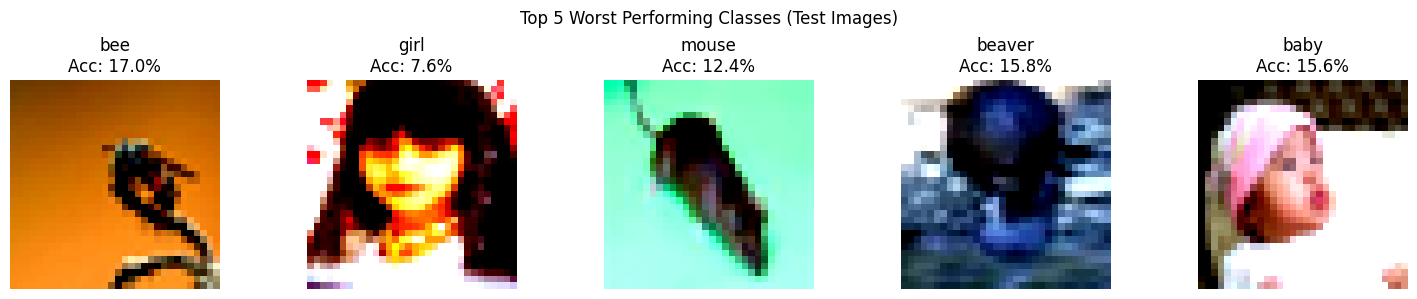

In [88]:
best_acc = np.argsort(accuracies)[-5:][::-1]
bad_acc = np.argsort(accuracies)[:5]

best_test_images = []
bad_test_images = []
found_best_test = set()
found_bad_test = set()

with torch.no_grad():
    for images, labels in test_loader:
        for img, label in zip(images, labels):
            label_item = label.item()
            if label_item in best_acc and label_item not in found_best_test:
                best_test_images.append((label_item, img))
                found_best_test.add(label_item)
            if label_item in bad_acc and label_item not in found_bad_test:
                bad_test_images.append((label_item, img))
                found_bad_test.add(label_item)
        if len(found_best_test) == 5 and len(found_bad_test) == 5:
            break

plt.figure(figsize=(15, 3))
for i, (label, img) in enumerate(best_test_images):
    img = img.numpy() * 0.5 + 0.5
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f"{classes[label]}\nAcc: {accuracies[label]:.1f}%")
    plt.axis('off')
plt.suptitle("Top 5 Best Performing Classes (Test Images)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 3))
for i, (label, img) in enumerate(bad_test_images):
    img = img.numpy() * 0.5 + 0.5
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f"{classes[label]}\nAcc: {accuracies[label]:.1f}%")
    plt.axis('off')
plt.suptitle("Top 5 Worst Performing Classes (Test Images)")
plt.tight_layout()
plt.show()

### Question
What do you think is the reason for the significant accuracy difference between different classes? What differences do you observe between the classes with the best and worst accuracy? Can you provide an analysis of the results and relate them to the model’s feature space?

Answer: models previous knowledge discriminates the classes very basic and only about the most differntiable features but in the next trying to classification we see that the model cant find out the diffrence between the girl or baby to the human and it shows that the model didnt works well in specification of subclasses.